# LLM

In [1]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
colab = False
base_path = '../'

if colab:
    base_path = '/content/drive/MyDrive/ NLP - final project/'

In [4]:
import pandas as pd
import seaborn as sns
SEED = 42

# Load data
data = pd.read_csv(f'{base_path}Data/train.csv')

## Data preprocessing

In [8]:
from sklearn.model_selection import train_test_split

SEED = 42
LLM_SAMPLE_SIZE = 200

# STEP 1: LOAD & CONSOLIDATE LABELS
df = data

toxicity_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Create a single binary target: If any column is 1, the text is Toxic (1)
df['final_label'] = df[toxicity_cols].max(axis=1)

print(f"Data loaded. Total rows: {len(df)}")
print(f"Toxic samples: {df['final_label'].sum()} | Non-Toxic samples: {len(df) - df['final_label'].sum()}")


# STEP 2: SPLIT & CREATE GOLDEN SAMPLE (80/20)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED)

# Now, extract the small "Golden Sample" specifically for the LLM
# We use .copy() to avoid SettingWithCopy warnings
llm_sample = test_df.sample(n=LLM_SAMPLE_SIZE, random_state=SEED).copy()

print(f"LLM Sample of {len(llm_sample)} rows (from Test set).")

# STEP 3: MINIMAL CLEANING
llm_sample['llm_prompt'] = llm_sample['comment_text'].str.replace('\n', ' ', regex=False)

# STEP 5: SAVE ARTIFACTS
output_cols = ['id', 'final_label', 'llm_prompt']
llm_sample[output_cols].to_csv(f'{base_path}Data/llm/llm_baseline_inputs.csv', index=False)


llm_sample['id'].to_csv(f'{base_path}Data/golden_sample_ids.csv', index=False)

print("\nProcessing complete!")
print("1. 'llm_baseline_inputs.csv' -> Feed this to your LLM.")
print("2. 'golden_sample_ids.csv' -> To filter RoBERTa predictions later.")

Data loaded. Total rows: 159571
Toxic samples: 16225 | Non-Toxic samples: 143346
LLM Sample of 200 rows (from Test set).

Processing complete!
1. 'llm_baseline_inputs.csv' -> Feed this to your LLM.
2. 'golden_sample_ids.csv' -> To filter RoBERTa predictions later.


## LLM INFERENCE

### Mistral

Loading model: mistralai/Mistral-7B-Instruct-v0.2...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Token ID for 'Yes': 5592
Token ID for 'No': 1770
Starting inference on 200 samples...


100%|██████████| 200/200 [01:09<00:00,  2.89it/s]


ROC-AUC SCORE: 0.9422
F1-SCORE     : 0.6809
AVG LATENCY  : 344.7304


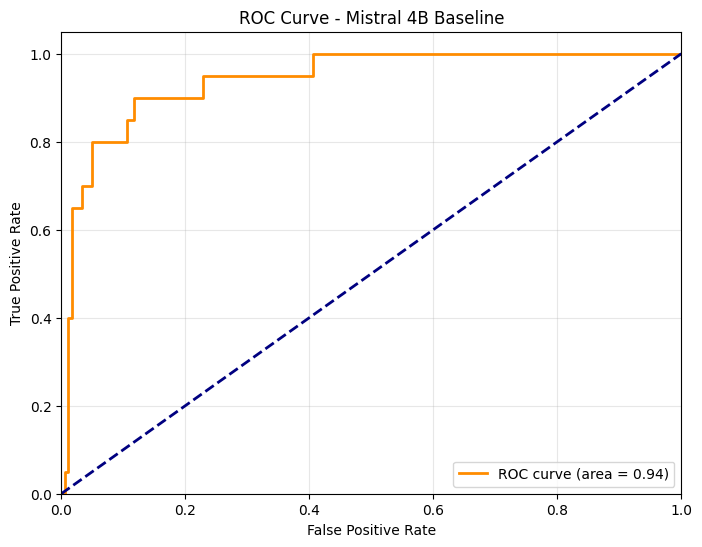

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score
from tqdm import tqdm
import time

# CONFIGURATION
MODEL_ID = "mistralai/Mistral-7B-Instruct-v0.2"
INPUT_FILE = f'{base_path}Data/llm/llm_baseline_inputs.csv'
OUTPUT_FILE = f'{base_path}Data/llm/mistral_prob_results.csv'

# 1. LOAD MODEL
print(f"Loading model: {MODEL_ID}...")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto"
)

# 2. IDENTIFY TOKEN IDs
# We want to compare the probability of "Yes" (Toxic) vs "No" (Non-Toxic)
yes_token_id = tokenizer.encode("Yes", add_special_tokens=False)[0]
no_token_id = tokenizer.encode("No", add_special_tokens=False)[0]

print(f"Token ID for 'Yes': {yes_token_id}")
print(f"Token ID for 'No': {no_token_id}")

# 3. PROBABILITY FUNCTION
def get_toxicity_score(text):
    prompt = f"""[INST] You are the best content moderator in the history.
                        You are very meticulous and pay close attention to
                        the meaning of each word and the overall context of
                        each text because if you don't perform extremely well,
                        you will lose your job and your company will close.
                        Is the following text toxic? Answer with 'Yes' or 'No' only.
                        \nText: \"{text}\"
                        \nAnswer: [/INST]"""

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits[0, -1, :]

    yes_score = logits[yes_token_id].item()
    no_score = logits[no_token_id].item()

    # Calculate Softmax Probability for "Yes" vs "No"
    prob_toxic = np.exp(yes_score) / (np.exp(yes_score) + np.exp(no_score))

    return prob_toxic

# 4. INFERENCE LOOP
df = pd.read_csv(INPUT_FILE)
print(f"Starting inference on {len(df)} samples...")

toxicity_scores = []
predictions = []
latencies = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['llm_prompt']
    start_time = time.time()

    try:
        prob = get_toxicity_score(text)
    except Exception as e:
        print(f"Error: {e}")
        prob = 0.5 # threshold

    end_time = time.time()
    latency_ms = (end_time - start_time) * 1000
    latencies.append(latency_ms)

    toxicity_scores.append(prob)
    predictions.append(1 if prob >= 0.5 else 0)

df['toxicity_prob'] = toxicity_scores
df['llm_pred'] = predictions
df['latency_ms'] = latencies


df.to_csv(OUTPUT_FILE, index=False)

# 5. METRICS & ROC CURVE
y_true = df['final_label']
y_scores = df['toxicity_prob']

# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
avg_latency = sum(latencies) / len(latencies)

print("\n" + "="*40)
print(f"ROC-AUC SCORE: {roc_auc:.4f}")
print(f"F1-SCORE     : {f1_score(y_true, predictions):.4f}")
print(f"AVG LATENCY  : {avg_latency:.4f}")
print("="*40)

# 6. PLOT ROC CURVE
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Mistral 4B Baseline')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [7]:
!pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 14.3 MB/s eta 0:00:00


# RoBERTa

## Data Preparation

In [12]:
from torch.utils.data import Dataset
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(data, test_size=0.1, random_state=SEED)

# 1. Define the Custom Dataset Class
class ToxicityDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = str(self.data.iloc[index]['comment_text'])
        label = self.data.iloc[index]['final_label']

        # Tokenize the text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# 2. Initialize Tokenizer & Create Datasets
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

# Create the PyTorch datasets
train_dataset = ToxicityDataset(train_df, tokenizer, max_len=128)
val_dataset = ToxicityDataset(val_df, tokenizer, max_len=128)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Training samples: 143613
Validation samples: 15958


## Model initialization

In [13]:
import torch
from transformers import AutoModelForSequenceClassification

# CONFIGURATION
MODEL_ID = "roberta-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Loading {MODEL_ID} for finetuning on {device}...")

# INITIALIZE MODEL
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_ID,
    num_labels=2,
    id2label={0: "Non-Toxic", 1: "Toxic"},
    label2id={"Non-Toxic": 0, "Toxic": 1}
)

# Move model to the GPU (Crucial for training speed)
model.to(device)

print("Model initialized successfully.")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading roberta-base for finetuning on cuda...
Model initialized successfully.


## Metrics

In [14]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred

    # 1. Convert Logits to Probabilities (Softmax)
    predictions = np.argmax(logits, axis=-1)

    # Calculate probabilities for the "Toxic" class (label 1)
    # Softmax formula: exp(x) / sum(exp(x))
    probs = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)
    probs_toxic = probs[:, 1]

    # 2. Calculate Metrics
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    roc_auc = roc_auc_score(labels, probs_toxic)

    return {
        'accuracy': acc,
        'f1': f1,
        'roc_auc': roc_auc
    }

## Training

In [15]:
from transformers import TrainingArguments, Trainer

# 1. HYPERPARAMETER SETUP
training_args = TrainingArguments(
    output_dir=f'{base_path}models/roberta-toxicity-finetuned',

    # Core Training Parameters
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,

    # Evaluation Strategy
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",

    # Logging & Optimization
    logging_steps=100,
    weight_decay=0.01,
    fp16=True,
    report_to="none"
)

# 2. INITIALIZE TRAINER
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# 3. START TRAINING
print("Starting training...")
trainer.train()

# 4. SAVE FINAL MODEL
save_path = f'{base_path}models'
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

print(f"Training finished. Model saved to {save_path}")

/tmp/ipython-input-2066479881.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Roc Auc
1,0.100400,0.102587,0.968104,0.844959,0.987312
2,0.071300,0.100752,0.971801,0.857234,0.988525


Training finished. Model saved to /content/drive/MyDrive/ NLP - final project/models


## Evaluation

In [17]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from transformers import TrainingArguments
from torch.utils.data import Dataset

# 1. CONFIGURATION
MODEL_PATH = f'{base_path}models'
TEST_TEXT_PATH = f'{base_path}Data/test.csv'
TEST_LABELS_PATH = f'{base_path}Data/test_labels.csv'

# 2. LOAD & PREPARE DATA
print("Loading test data...")

# Load the files
test_text = pd.read_csv(TEST_TEXT_PATH)
test_labels = pd.read_csv(TEST_LABELS_PATH)

test_df = test_text.merge(test_labels, on='id')

# CRITICAL: Remove rows with label -1 (Jigsaw uses -1 for excluded samples)
test_df = test_df[test_df['toxic'] != -1]

# Create the binary 'final_label' (Any toxic category = 1, otherwise 0)
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
test_df['final_label'] = test_df[label_cols].max(axis=1)

print(f"Valid Test Samples: {len(test_df)}")

# INITIALIZE MODEL
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_PATH
)

# Use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Create dataset
test_dataset = ToxicityDataset(test_df, tokenizer)

# RUN EVALUATION USING TRAINER
trainer = Trainer(
    model=model,
    args=TrainingArguments(output_dir=f'{base_path}models/eval_output', per_device_eval_batch_size=64, report_to="none"),
)

print("Running prediction...")
predictions = trainer.predict(test_dataset)

# CALCULATE METRICS
preds = np.argmax(predictions.predictions, axis=-1)
probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1)[:, 1].numpy()
labels = predictions.label_ids

acc = accuracy_score(labels, preds)
f1 = f1_score(labels, preds)
roc = roc_auc_score(labels, probs)

print("\n" + "="*30)
print("   FULL TEST SET RESULTS")
print("="*30)
print(f"SAMPLES     : {len(test_df)}")
print(f"ACCURACY    : {acc:.4f}")
print(f"F1-SCORE    : {f1:.4f}")
print(f"ROC-AUC     : {roc:.4f}")
print("="*30)
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=['Non-Toxic', 'Toxic']))

Loading test data...
Valid Test Samples: 63978
Running prediction...



   FULL TEST SET RESULTS
SAMPLES     : 63978
ACCURACY    : 0.9133
F1-SCORE    : 0.6729
ROC-AUC     : 0.9707

Classification Report:
              precision    recall  f1-score   support

   Non-Toxic       0.99      0.91      0.95     57735
       Toxic       0.53      0.91      0.67      6243

    accuracy                           0.91     63978
   macro avg       0.76      0.91      0.81     63978
weighted avg       0.95      0.91      0.92     63978



## Test

Loading RoBERTa from /content/drive/MyDrive/ NLP - final project/models...
Running RoBERTa on 200 samples...

METRIC          | LLM (Mistral)   | RoBERTa (Yours)
--------------------------------------------------
ROC-AUC         | 0.94        | 0.99
F1-Score        | 0.6809          | 0.9000
Avg Latency     | 344.73 ms        | 20.12 ms
Speedup Factor  | 1.0x            | 17.1x FASTER


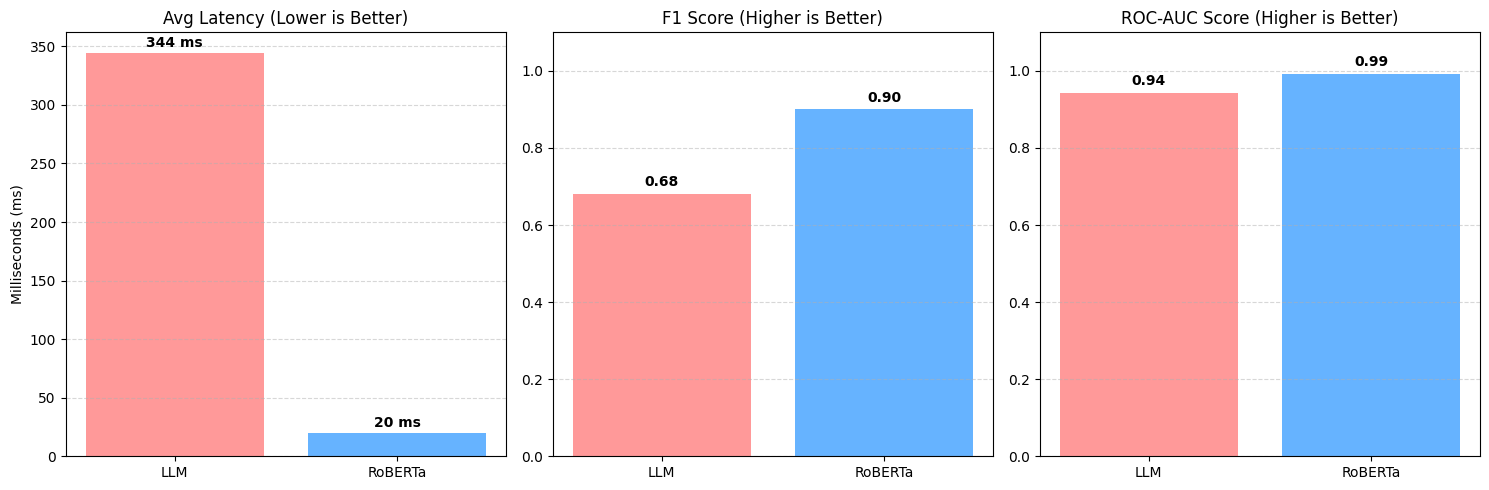

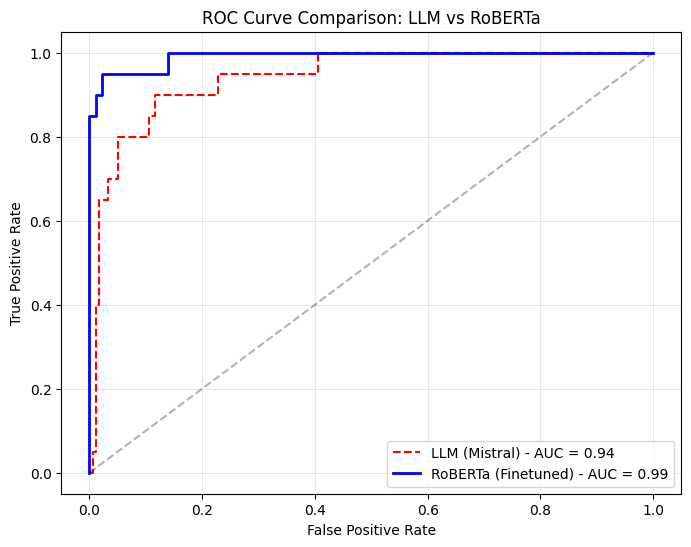

In [19]:
import torch
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve

# CONFIGURATION
ROBERTA_PATH = f'{base_path}models'
LLM_RESULTS_FILE = f'{base_path}Data/llm/mistral_prob_results.csv'
INPUT_FILE = f'{base_path}Data/llm/llm_baseline_inputs.csv'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. RUN ROBERTA INFERENCE
print(f"Loading RoBERTa from {ROBERTA_PATH}...")
tokenizer = AutoTokenizer.from_pretrained(ROBERTA_PATH)
model = AutoModelForSequenceClassification.from_pretrained(ROBERTA_PATH)
model.to(device)
model.eval()

df = pd.read_csv(INPUT_FILE)
print(f"Running RoBERTa on {len(df)} samples...")

roberta_preds = []
roberta_probs = []
roberta_latencies = []

for i, row in df.iterrows():
    text = str(row['llm_prompt'])

    start_time = time.time()

    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128, padding="max_length").to(device)
    with torch.no_grad():
        logits = model(**inputs).logits

    end_time = time.time()
    roberta_latencies.append((end_time - start_time) * 1000)

    probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]
    roberta_probs.append(probs[1])
    roberta_preds.append(1 if probs[1] >= 0.5 else 0)

df['roberta_pred'] = roberta_preds
df['roberta_prob'] = roberta_probs
df['roberta_latency'] = roberta_latencies

# 2. LOAD LLM RESULTS & COMPARE
llm_df = pd.read_csv(LLM_RESULTS_FILE)
llm_latency_mean = llm_df['latency_ms'].mean()
llm_f1 = f1_score(llm_df['final_label'], llm_df['llm_pred'])
llm_auc = roc_auc_score(llm_df['final_label'], llm_df['toxicity_prob'])
llm_fpr, llm_tpr, _ = roc_curve(llm_df['final_label'], llm_df['toxicity_prob'])

# RoBERTa Metrics
roberta_latency_mean = np.mean(roberta_latencies)
roberta_f1 = f1_score(df['final_label'], df['roberta_pred'])
roberta_auc = roc_auc_score(df['final_label'], df['roberta_prob'])
rob_fpr, rob_tpr, _ = roc_curve(df['final_label'], roberta_probs)

# Print Side-by-Side Table
print("\n" + "="*50)
print(f"{'METRIC':<15} | {'LLM (Mistral)':<15} | {'RoBERTa (Yours)':<15}")
print("-" * 50)
print(f"{'ROC-AUC':<15} | {llm_auc:.2f}        | {roberta_auc:.2f}")
print(f"{'F1-Score':<15} | {llm_f1:.4f}          | {roberta_f1:.4f}")
print(f"{'Avg Latency':<15} | {llm_latency_mean:.2f} ms        | {roberta_latency_mean:.2f} ms")
print(f"{'Speedup Factor':<15} | {'1.0x':<15} | {llm_latency_mean/roberta_latency_mean:.1f}x FASTER")
print("="*50)


# 3. VISUALIZATION

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
models = ['LLM', 'RoBERTa']
colors = ['#ff9999', '#66b3ff']

# Subplot 1: Latency
axes[0].bar(models, [llm_latency_mean, roberta_latency_mean], color=colors)
axes[0].set_title('Avg Latency (Lower is Better)')
axes[0].set_ylabel('Milliseconds (ms)')
axes[0].grid(axis='y', linestyle='--', alpha=0.5)
for i, v in enumerate([llm_latency_mean, roberta_latency_mean]):
    axes[0].text(i, v + 5, f"{int(v)} ms", ha='center', fontweight='bold')

# Subplot 2: F1 Score
axes[1].bar(models, [llm_f1, roberta_f1], color=colors)
axes[1].set_title('F1 Score (Higher is Better)')
axes[1].set_ylim(0, 1.1)
axes[1].grid(axis='y', linestyle='--', alpha=0.5)
for i, v in enumerate([llm_f1, roberta_f1]):
    axes[1].text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')

# Subplot 3: ROC-AUC
axes[2].bar(models, [llm_auc, roberta_auc], color=colors)
axes[2].set_title('ROC-AUC Score (Higher is Better)')
axes[2].set_ylim(0, 1.1)
axes[2].grid(axis='y', linestyle='--', alpha=0.5)
for i, v in enumerate([llm_auc, roberta_auc]):
    axes[2].text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('comparison_metrics.png')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(llm_fpr, llm_tpr, label=f'LLM (Mistral) - AUC = {llm_auc:.2f}', linestyle='--', color='red')
plt.plot(rob_fpr, rob_tpr, label=f'RoBERTa (Finetuned) - AUC = {roberta_auc:.2f}', color='blue', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.3) # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: LLM vs RoBERTa')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.savefig('comparison_roc_curve.png')
plt.show()

## Explicabilité

In [17]:
!pip install shap

Device set to use mps:0
/Users/sagnolkamdem/projects/cours/5A/NLP & GenAI/Projet final/ NLP - final project/.venv/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Generating explanations...


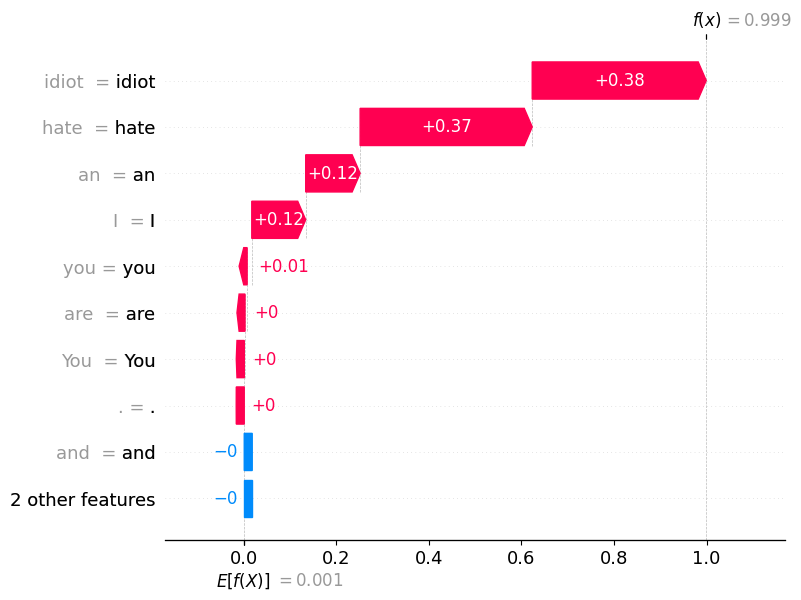

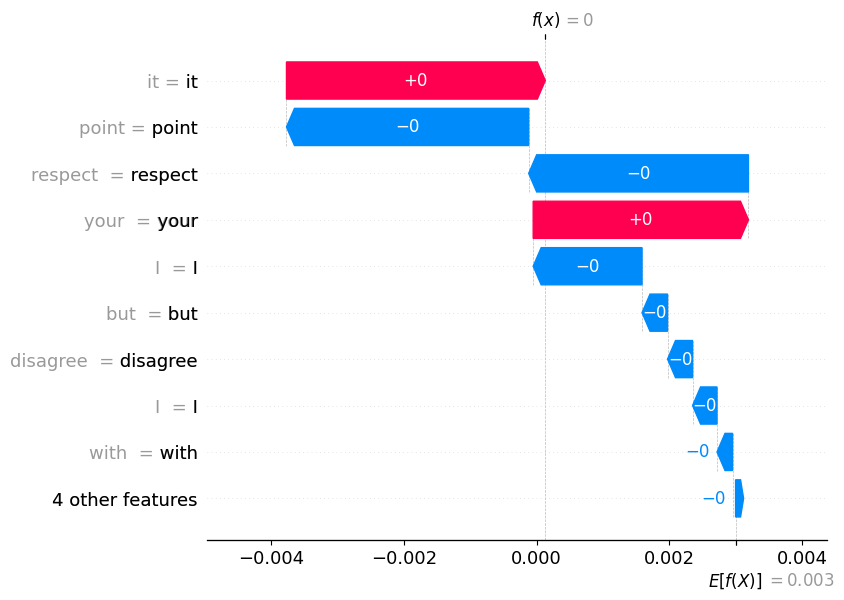

In [7]:
import shap
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

# CONFIGURATION
MODEL_PATH = f'{base_path}models'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. LOAD MODEL & PIPELINE
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH).to(device)
p = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0, return_all_scores=True)

# 2. DEFINE EXPLAINER
explainer = shap.Explainer(p)

# 3. SELECT SAMPLES TO EXPLAIN
samples = [
    "You are an idiot and I hate you.",              # Clear Toxic
    "I disagree with your point, but I respect it."  # Non-Toxic
]

print("Generating explanations...")
shap_values = explainer(samples)

# 4. VISUALIZE
# shap.plots.text(shap_values[:, :, 1])
# shap.plots.bar(shap_values[0, :, 1])
shap.plots.waterfall(shap_values[0, :, 1])
shap.plots.waterfall(shap_values[1, :, 1])